In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/text-generation/text-generation.h5
/kaggle/input/text-generation/__results__.html
/kaggle/input/text-generation/__output__.json
/kaggle/input/text-generation/custom.css
/kaggle/input/text-generation/__notebook__.ipynb
/kaggle/input/text-generation/text-generation-enhanced.h5
/kaggle/input/text-generation/__results___files/__results___10_1.png
/kaggle/input/testingg/sonnet.txt
/kaggle/input/shakespeare-plays/william-shakespeare-black-silhouette.jpg
/kaggle/input/shakespeare-plays/Shakespeare_data.csv
/kaggle/input/shakespeare-plays/alllines.txt


In [2]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as np_utils



In [3]:
sonnet = open('/kaggle/input/testingg/sonnet.txt', 'r', encoding = 'utf-8').read()
sonnet = sonnet.lower()
sonnet = sonnet.split("\n")
print(sonnet[:10])

['the sonnets', '', 'by william shakespeare', '', 'from fairest creatures we desire increase,', "that thereby beauty's rose might never die,", 'but as the riper should by time decease,', 'his tender heir might bear his memory:', 'but thou contracted to thine own bright eyes,', "feed'st thy light's flame with self-substantial fuel,"]


In [4]:
print(len(sonnet))

2469


In [5]:
import string
def clean_text(text):
    txt = "".join(ch for ch in text if ch not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt

corpus = [clean_text(line) for line in sonnet]
corpus[:7]

['the sonnets',
 '',
 'by william shakespeare',
 '',
 'from fairest creatures we desire increase',
 'that thereby beautys rose might never die',
 'but as the riper should by time decease']

In [6]:
t = Tokenizer()
t.fit_on_texts(corpus)


In [7]:
total_words = len(t.word_index) + 1
input_sequences = []
#Generate Sequences
for line in corpus:
    tokens = t.texts_to_sequences([line])[0]
    for i in range(1, len(tokens)):
        n_grams = tokens[: i+1]
        input_sequences.append(n_grams)
input_sequences[:10]

[[2, 1357],
 [31, 1358],
 [31, 1358, 1359],
 [34, 406],
 [34, 406, 861],
 [34, 406, 861, 161],
 [34, 406, 861, 161, 211],
 [34, 406, 861, 161, 211, 501],
 [8, 862],
 [8, 862, 132]]

In [8]:
#pad all the sequences to same length
max_len = max([len(seq) for seq in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_len, padding = 'pre'))
x_train, y_train = input_sequences[:, :-1], input_sequences[:, -1]
y_train = np_utils.to_categorical(y_train, num_classes = total_words)
x_train.shape, y_train.shape

((15431, 10), (15431, 3182))

In [9]:
total_words, max_len

(3182, 11)

In [10]:
import tensorflow as tf
model = tf.keras.Sequential() # define your model normally
model.add(Embedding(total_words, 10, input_length = max_len - 1))
model.add(LSTM(512, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(512))
model.add(Dropout(0.2))
model.add(Dense(total_words, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 10)            31820     
_________________________________________________________________
lstm (LSTM)                  (None, 10, 512)           1071104   
_________________________________________________________________
dropout (Dropout)            (None, 10, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3182)              1632366   
Total params: 4,834,490
Trainable params: 4,834,490
Non-trainable params: 0
______________________________________________

In [11]:
callbacks = [ModelCheckpoint("poem-sonnet.h5", monitor = 'loss', mode = 'min', save_best_only = True)]
history = model.fit(x_train[:15360], y_train[:15360], epochs = 1000, batch_size = 128, callbacks = callbacks)

Train on 15360 samples
Epoch 1/1000
15360/15360 [==============================] - 7s 463us/sample - loss: 6.9069
Epoch 2/1000
15360/15360 [==============================] - 2s 104us/sample - loss: 6.5699
Epoch 3/1000
15360/15360 [==============================] - 2s 108us/sample - loss: 6.5050
Epoch 4/1000
15360/15360 [==============================] - 2s 103us/sample - loss: 6.4526
Epoch 5/1000
15360/15360 [==============================] - 2s 105us/sample - loss: 6.3998
Epoch 6/1000
15360/15360 [==============================] - 2s 105us/sample - loss: 6.3376
Epoch 7/1000
15360/15360 [==============================] - 2s 102us/sample - loss: 6.2590
Epoch 8/1000
15360/15360 [==============================] - 2s 103us/sample - loss: 6.1795
Epoch 9/1000
15360/15360 [==============================] - 2s 107us/sample - loss: 6.0859
Epoch 10/1000
15360/15360 [==============================] - 2s 110us/sample - loss: 5.9828
Epoch 11/1000
15360/15360 [==============================] - 2s 10

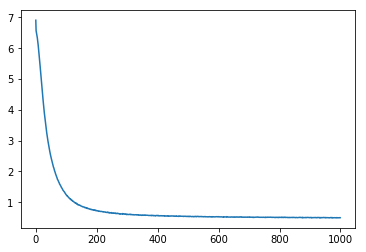

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [13]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = t.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list)
        
        output_word = ""
        for word,index in t.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()


In [14]:
print ("1. ",generate_text("Julius", 20, model, max_len))
print ("2. ",generate_text("Thou", 20, model, max_len))
print ("3. ",generate_text("King is", 20, model, max_len))
print ("4. ",generate_text("Death of", 20, model, max_len))
print ("5. ",generate_text("The Princess", 20, model, max_len))
print ("6. ",generate_text("Thanos", 20, model, max_len))

1.  Julius The World Will Be Thy Widow And Still Weep Are He In Thee It Green Thee Now It Night It
2.  Thou Art As Fair In Knowledge As In Hue That Is So Bevel Grace You Long Doth Eyes Eyes See Thee
3.  King Is My Home Of Love If I Have Ranged See Rolling Dearer Lies Had Thee Date Look In You Delight Held
4.  Death Of Thy Face Sweet Self Will Ever Dwell Room That In Thee It Wanting It Still Thee You Thee Thee Swearing
5.  The Princess World Will Be Thy Widow And Still Weep Are He In Thee It Green Thee Now It Night It Last
6.  Thanos The World Will Be Thy Widow And Still Weep Are He In Thee It Green Thee Now It Night It


In [15]:
print ("6. ",generate_text("Hello my dear", 200, model, max_len))

6.  Hello My Dear Loves Beauty Though My Lovers Life Still Decay Knowing Thee It Of Me More Hate Thee Thee Green Thee Now Go Heaven It Date Both Did Check Thee Me Thee Me Are Live It Thee Now I Do Thee Thee You Green Thee Last Of Thee Ill Cover The Canopy Of Such Day Thee Thee You Wanting Fair Eyes Will See Thee From Thee You Doth Come The Even Still Doom Shines Life Is Crave As So More Rhyme In Constant Heart To Light Before Hid That Go Gone Can You Have Erred You Press Best In Thee Green It Have Devised With Me Green Thee Him It Are Lie Thee Thee Mine Sweet Desert Can Speak Still Are In Thee More Due New Expressed Thought Thee Thee Thee Swearing Muse Me Green It Have As Kind So Read Me Thee My Mind Indeed Greeing Shine Erred Call So The Muse Can Flatter It Dead Days Hid Loved Thee Due Of Doubt He You So Say Thee Crime Mine Eyes Had Rolling Mens Spent Despised Expressed Thee Seeming New Eyes Those Praise Away Thee Quite As To Call Thee To My Love Had Brought That Are My Common Defeat 

In [16]:

print ("6. ",generate_text("read my the", 200, model, max_len))

6.  Read My The World Do I Now Fortify Me Back That To It See Thee Thee Again With All My Might Eyes Cease Mayst Did Other Gone Still See Thee Wanting Deeds In Thee Is Wanting Might Can Nearly Years Bright Away Thee You Still So Reap Will See Call Room I Had Thee Thee It Lies Remembered Thee Still Green Thee Trust My State Is Greeing Strong Gone Sweet Shine Mine In Call To That Wanting Feature Is Greeing Thy Gain Away Thee You In Me Lie It Live It Recompense Die Thee Again It So Tell Thee Blind Must Less The Tomb Appear Date Store To Write Thee Light Thee Hid Of In Thee With It Still My State With In Thy Love His Mind Still You Still My Stain One Live Weep Room Show Thee Me It Cover Thee More Might Can Say You Long Thee Thee Thee Me So Lies It New Say More Twain In Doubt That Wanting Tomb Thee Me Thee Wanting Might Can Nearly His Will Well Die Thee My Due Been Sit Fair In Thee Thee The Spring Of Life His State Is Thee Repair Pride Thee Convertest Go Feature Me Loved Me Life Doth


In [17]:
print ("6. ",generate_text("Once upon a Time", 200, model, max_len))

6.  Once Upon A Time And Filled His Brow Die End Thee More Hath Give So Dearer More Slain Write The Spring Of Life To Grew Which It Not Not So Crime Away Rolling Have As Night Thee Spend That So Woe Thee Thee Green This Head Must Sit Afford See Thee I Do Change Me Thee The Tomb Of Life Me Crave His Show Is You Still Are Write In Truth Can Woe With Thee Behold It Dearer Took Sad State Of Good Day Of Thee Held Knowing Thee Truth Of It So Shows Thee Thee Behold Such Sort Thee Thee Call Men One With Fulness Green The Spring Of Meetness Your Rose To Night Her Dearly My End Away Thee Quite Still To Thee Her More Eyes Rehearse Find Thee Such Had Thee Strife In Me Thee Green It Done Doth Love Grace Thee Kings Is Night Of Me As It To Have Dost Cured Thee Of Such Sort Are Sing Thee Thee Thee Wanting Old Child Of Mind Of Groan Of Your Face Was Live It Not So Free Can Boast You Not Thee Thee Tendered Green Me Last It Dote By So Need Of Thee In Such Sort More Must Before


In [18]:
model.load_weights('/kaggle/working/poem-sonnet.h5')
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
print ("6. ",generate_text("Once upon a Time", 200, model, max_len))
model.save("poem-writer.h5")

6.  Once Upon A Time And Filled His Brow Die Hid Young Know Me So Must Had So Part Thee Bring Green So One And Think Me Bring They So Confined Will Can Will Must See Nor Thee It So Done Be Old Told Can See Thee So Lies Change Me You More Mine Eyes Free See Is Wanting Hate In Thee Is Wanting Tomb Thee Blind Thee Wanting Words Still Pace Showst Well So Great Hell Me True Will Prove Thee More Will Prove Thee Is Tell Me Pain Me More Are Are With So Lies Nor Have Eyes Level Rolling Heart Me So The Tomb Me Thee They Time Knows Thee Me Eye More Fair Worth Sad Shade Base Spend Find Me Tongue Is True Though Prove Thee Is Men Set Me Last Me More To I Long Grow Halt Be Free Be See More True Before Still Mens Hell Me Thee More Cover It Prove Thee More Still Prove Me Lies Told In Thee Green Hue Thee Green Me Spend By Thou Have Grow Alone Say This Art Tell Be Write Thee Thee More Lie Away Thee One Green Thee Pain Thy Heaven Doth Flatter Me Thee All Thee Thee Is Doth
